In [18]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [19]:
root_path = 'gdrive/My Drive/Colab Notebooks/ML/'
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 
!pip install tensorboard --upgrade

Requirement already up-to-date: tensorboard in /usr/local/lib/python3.7/dist-packages (2.4.1)


In [20]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [21]:
# Data augmentation and normalization for training
# Just normalization for validation
transformer=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.485,0.456,0.406], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.485,0.456,0.406])
])


train_path= root_path + 'train'
test_path= root_path + 'test'
val_path = root_path + 'val'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=32, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

val_loader=DataLoader(
    torchvision.datasets.ImageFolder(val_path,transform=transformer),
    batch_size=32, shuffle=True
)

root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

['blackgrass', 'charlock', 'cleavers', 'fat hen', 'maize', 'wheat']


In [22]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=128 * 128 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            
        output=output.view(-1,32*128*128)
            
            
        output=self.fc(output)
            
        return output

In [23]:
model=ConvNet(num_classes=6).to(device)
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
num_epochs=10

In [24]:
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count



    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_val.model')
        best_accuracy=test_accuracy

writer.flush()
writer.close()

Epoch: 0 Train Loss: tensor(48.0541) Train Accuracy: 0.4133644133644134 Test Accuracy: 0.4684466019417476
Epoch: 1 Train Loss: tensor(7.6080) Train Accuracy: 0.6907536907536908 Test Accuracy: 0.7694174757281553
Epoch: 2 Train Loss: tensor(4.8495) Train Accuracy: 0.7902097902097902 Test Accuracy: 0.6723300970873787
Epoch: 3 Train Loss: tensor(3.9756) Train Accuracy: 0.8337218337218337 Test Accuracy: 0.6480582524271845
Epoch: 4 Train Loss: tensor(3.9161) Train Accuracy: 0.8445998445998446 Test Accuracy: 0.779126213592233
Epoch: 5 Train Loss: tensor(2.3391) Train Accuracy: 0.898989898989899 Test Accuracy: 0.662621359223301
Epoch: 6 Train Loss: tensor(2.2602) Train Accuracy: 0.8927738927738927 Test Accuracy: 0.7135922330097088
Epoch: 7 Train Loss: tensor(5.4692) Train Accuracy: 0.8445998445998446 Test Accuracy: 0.7160194174757282
Epoch: 8 Train Loss: tensor(3.8080) Train Accuracy: 0.8912198912198912 Test Accuracy: 0.808252427184466
Epoch: 9 Train Loss: tensor(3.8383) Train Accuracy: 0.9005

tensor([[59.,  0.,  0.,  0.,  0.,  1.],
        [ 1., 84.,  4.,  1.,  0.,  0.],
        [ 4.,  3., 55.,  1.,  0.,  5.],
        [39.,  2.,  1., 51.,  2.,  5.],
        [ 1.,  1.,  1.,  0., 41.,  2.],
        [24.,  1.,  1.,  0.,  0., 22.]])
tensor([0.9833, 0.9333, 0.8088, 0.5100, 0.8913, 0.4583])


Text(0.5, 69.0, 'Predicted label')

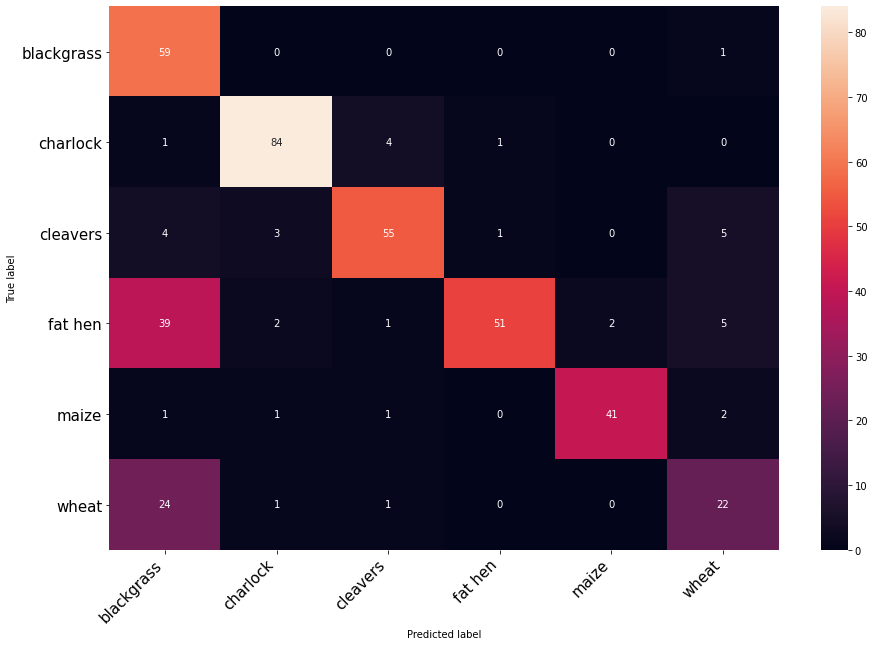

In [25]:
confusion_matrix = torch.zeros(6, 6)
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, pred = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] +=1

print(confusion_matrix)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

plt.figure(figsize=(15,10))
df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
!tensorboard dev upload --logdir runs \
--name "My latest experiment" \
--description "Simple comparison of several hyperparameters"

2021-03-24 22:39:02.418961: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

runs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scop